# 11.8 Lab: Survival Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import rpy2.robjects as robjects
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import pandas2ri

from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test

import survive

from sksurv.compare import compare_survival
import sksurv

%load_ext rpy2.ipython

## 11.8.1 Brain Cancer Data

In [2]:
%%R
library(ISLR2)
names(BrainCancer)

[1] "sex"       "diagnosis" "loc"       "ki"        "gtv"       "stereo"   
[7] "status"    "time"     


In [3]:
data = robjects.r("""
library(ISLR2)
xdata <- BrainCancer
""")
with localconverter(robjects.default_converter + pandas2ri.converter):
    brain_cancer_df = robjects.conversion.rpy2py(data)
    
brain_cancer_df.columns.values.tolist()

['sex', 'diagnosis', 'loc', 'ki', 'gtv', 'stereo', 'status', 'time']

In [4]:
%%R
attach(BrainCancer)
table(sex)

sex
Female   Male 
    45     43 


In [5]:
brain_cancer_df['sex'].value_counts().to_frame().T

,Female,Male
sex,45,43


In [6]:
%%R
table(diagnosis)

diagnosis
Meningioma  LG glioma  HG glioma      Other 
        42          9         22         14 


In [7]:
brain_cancer_df['diagnosis'].value_counts().sort_index().to_frame().T

,Meningioma,LG glioma,HG glioma,Other
diagnosis,42,9,22,14


In [8]:
%%R
table(status)

status
 0  1 
53 35 


In [9]:
brain_cancer_df['status'].value_counts().to_frame().T

,0,1
status,53,35


### Kaplan Meier Survival Curve

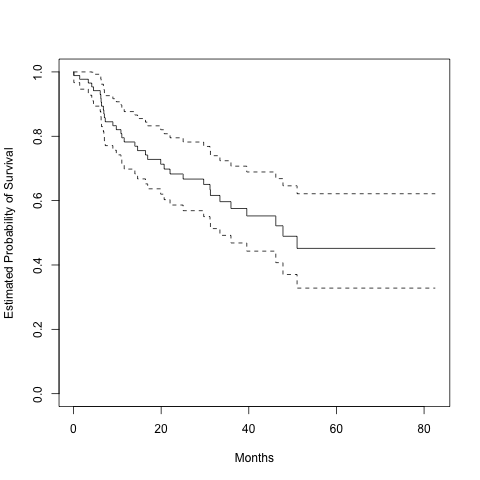

In [10]:
%%R
library(survival)
fit.surv <- survfit(Surv(time, status) ~ 1)
plot(fit.surv, xlab = 'Months',
    ylab = 'Estimated Probability of Survival')

#### Different Python Libraries
In Python, there are several libraries that can replicate parts of what R does in this lab, however I was unable to find any single library that did *all* of the things that R did.  The closest to an exact match was the `lifelines` library, as it could fit both KaplanMeier and CoxPH models, however there were a few areas that it fell short.

Another Python library, `survive`, could only fit KaplanMeier models, but the use of this library felt very similar to that of R.  For instance, there is a `survive.SurvivalData()` object that one can create based on time and status information from your dataset, which behaves in exactly the same way as the `Surv()` function in R.  After creating the object containing the survival data in R or Python, you then fit the model to that data.

Lastly, there's a Python library I didn't explore as much as the other two called `scikit-survival`.  This library was able to mimic the behavior of R's `survdiff()` function where `lifelines` and `survive` could not.

##### Using Lifelines

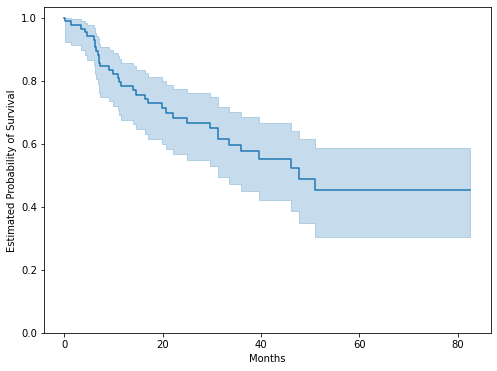

In [11]:
kmf_ll = KaplanMeierFitter()
kmf_ll.fit(durations=brain_cancer_df['time'], event_observed=brain_cancer_df['status'])

fig, ax = plt.subplots(1,1, figsize=(8,6))

kmf_ll.plot_survival_function()
plt.xlabel('Months')
plt.yticks(np.arange(0, 1.1, 0.2))
plt.ylabel('Estimated Probability of Survival')
ax.get_legend().remove();

By default, `lifelines` represents the uncertainty of the estimate using shading on the graph to represent the confidence interval for each timepoint, which is different than in R.  By tinkering with `matplotlib` some, this can be overcome, but would be overkill and unncessary.

##### Using Survive

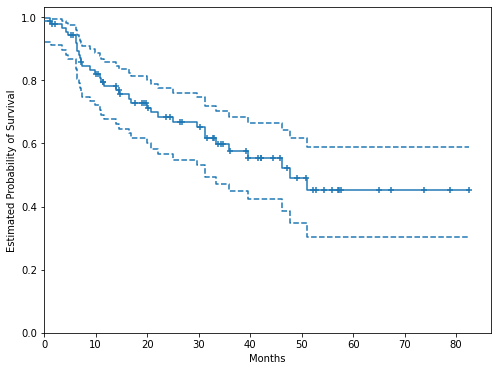

In [12]:
brain_cancer_df['status'] = np.float64(brain_cancer_df['status'])

kmf_surv = survive.KaplanMeier()

surv_data = survive.SurvivalData(time=brain_cancer_df['time'], status=brain_cancer_df['status'])

kmf_surv_fit = kmf_surv.fit(surv_data)

fig, ax = plt.subplots(1,1, figsize=(8,6))

kmf_surv_fit.plot(ci_style='lines', ax=ax)
plt.xlabel('Months')
plt.ylabel('Estimated Probability of Survival');

`survive` represents the confidence intervals using dashed lines as opposed to the shading of `lifelines`.  By default, the curve also shows vertical bars representing censoring events, something that R doesn't do.

#### By Gender

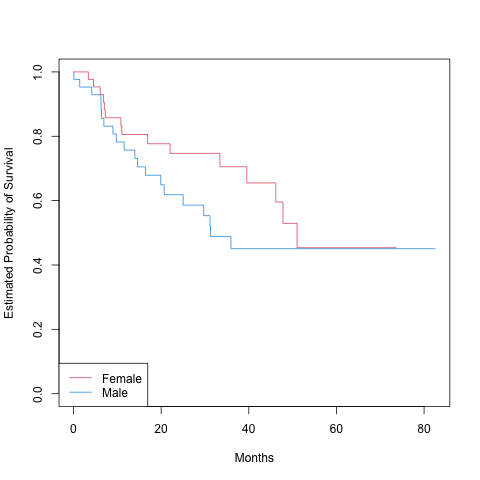

In [13]:
%%R
fit.sex <- survfit(Surv(time, status) ~ sex)
plot(fit.sex, xlab = 'Months',
    ylab = 'Estimated Probability of Survival', col = c(2,4))
legend('bottomleft', levels(sex), col = c(2,4), lty = 1)

##### Using Lifelines

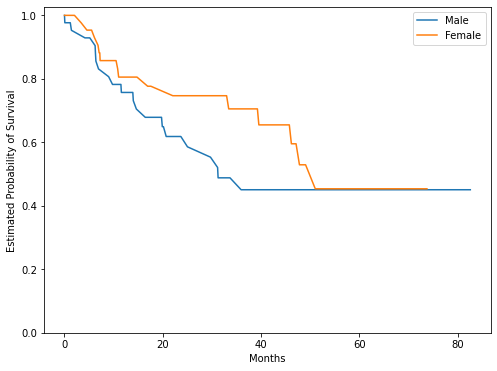

In [14]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

male = (brain_cancer_df['sex'] == 'Male')
female = (brain_cancer_df['sex'] == 'Female')

kmf_ll.fit(brain_cancer_df['time'][male], event_observed=brain_cancer_df['status'][male], label='Male')
kmf_ll.survival_function_.plot(ax=ax)

kmf_ll.fit(brain_cancer_df['time'][female], event_observed=brain_cancer_df['status'][female], label='Female')
kmf_ll.survival_function_.plot(ax=ax)

plt.xlabel('Months')
plt.yticks(np.arange(0, 1.1, 0.2))
plt.ylabel('Estimated Probability of Survival');

With `lifelines` it's also possible to plot the survival curve for different levels of a predictor, such as gender in this case, and without any shading representing the confidence intervals.  Unfortunately, `lifelines` won't automatically generate a plot for each level of the predictor.  Instead, we have to partition the dataset by level, fit the model once for each partition of the data, and then plot the survival curve on a shared axis.

##### Using Survive

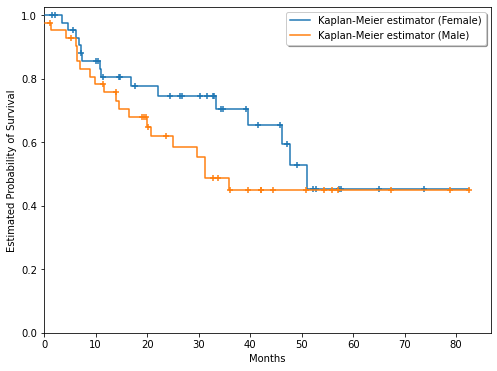

In [15]:
brain_cancer_df['status'] = np.float64(brain_cancer_df['status'])

kmf_surv = survive.KaplanMeier()

surv_data = survive.SurvivalData(time='time', status='status', group='sex', data=brain_cancer_df)

kmf_surv_fit = kmf_surv.fit(surv_data)

fig, ax = plt.subplots(1,1, figsize=(8,6))

kmf_surv.plot(ax=ax, ci=False)

plt.xlabel('Months')
plt.yticks(np.arange(0, 1.1, 0.2))
plt.ylabel('Estimated Probability of Survival');

`survive` is a little easier to use when plotting a survival curve based on different levels of a predictor, as one can specify the `group=` parameter and it will automatically fit a different survival curve and plot it for each level of the predictor.

### Log-Rank Test

In [16]:
%%R
logrank.test <- survdiff(Surv(time, status) ~ sex)
logrank.test

Call:
survdiff(formula = Surv(time, status) ~ sex)

            N Observed Expected (O-E)^2/E (O-E)^2/V
sex=Female 45       15     18.5     0.676      1.44
sex=Male   43       20     16.5     0.761      1.44

 Chisq= 1.4  on 1 degrees of freedom, p= 0.2 


#### Using Lifelines

In [17]:
male = (brain_cancer_df['sex'] == 'Male')
female = (brain_cancer_df['sex'] == 'Female')

results = logrank_test(brain_cancer_df['time'][male], 
                       brain_cancer_df['time'][female],
                       event_observed_A=brain_cancer_df['status'][male],
                       event_observed_B=brain_cancer_df['status'][female]
                      )

results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           1.44 0.23      2.12

`lifelines` was able to perform a Log-Rank test, however the output wasn't as verbose as the ouput found in R.  Both R and Python had the same chi-square test_statistic, degrees of freedom, p-value, and -log2(p), but R also showed the group sizes, as well as observed and expected counts.

#### Using survive
As far as I was able to tell, the `survive` library didn't have any way to perform a Log-Rank test.

#### Using scikit-survival
`scikit-survival` was able to peform the Log-Rank test and generate output that most closely resembled R's output, however it was still missing a thing or two.

In [18]:
x = []

for item in zip(brain_cancer_df['status'].astype(bool), brain_cancer_df['time']):
    x.append(item)

x = np.array(x, dtype='bool,f').flatten()

test_stat, p_val, surv_counts, covar = compare_survival(x, brain_cancer_df['sex'], return_stats=True)

print(f'Scikit-survival Chi-Square Test Statistic: {test_stat:.3f}')
print(f'Scikit-survival P-Value: {p_val:.4f}')
surv_counts

Scikit-survival Chi-Square Test Statistic: 1.440
Scikit-survival P-Value: 0.2301


,counts,observed,expected,statistic
group,,,,
Female,45,15,18.539466,-3.539466
Male,43,20,16.460534,3.539466


### Cox Proportional Hazards (CoxPH) model

In [19]:
%%R
fit.cox <- coxph(Surv(time, status) ~ sex)
summary(fit.cox)

Call:
coxph(formula = Surv(time, status) ~ sex)

  n= 88, number of events= 35 

          coef exp(coef) se(coef)     z Pr(>|z|)
sexMale 0.4077    1.5033   0.3420 1.192    0.233

        exp(coef) exp(-coef) lower .95 upper .95
sexMale     1.503     0.6652     0.769     2.939

Concordance= 0.565  (se = 0.045 )
Likelihood ratio test= 1.44  on 1 df,   p=0.2
Wald test            = 1.42  on 1 df,   p=0.2
Score (logrank) test = 1.44  on 1 df,   p=0.2



#### Different Python Libraries
I didn't play around with `scikit-survival` for CoxPH models, however the [documentation](https://scikit-survival.readthedocs.io/en/stable/api/generated/sksurv.linear_model.CoxPHSurvivalAnalysis.html) indicates it should be possible.  

The `survive` library wasn't able to fix CoxPH models, however `lifelines` could, and will be used predominantly for the remainder of the lab.

##### Using Lifelines and sex as a predictor

In [20]:
cph_ll = CoxPHFitter()
cph_ll_fit = cph_ll.fit(brain_cancer_df, 'time', 'status', formula='sex')

cph_ll_fit.print_summary()

<lifelines.CoxPHFitter: fitted with 88 total observations, 53 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 88
number of events observed = 35
   partial log-likelihood = -137.43
         time fit was run = 2023-01-30 07:20:06 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
sex[T.Male]   0.41       1.50       0.34            -0.26             1.08                 0.77                 2.94

              cmp to    z    p   -log2(p)
covariate                                
sex[T.Male]     0.00 1.19 0.23       2.10
---
Concordance = 0.56
Partial AIC = 276.86
log-likelihood ratio test = 1.44 on 1 df
-log2(p) of ll-ratio test = 2.12

`lifelines` matches R's output, for the most part.  There are some minor differences like R showing output for the Wald Test, or the score of the logrank test, while `lifelines` shows a confidence interval for both the coef and the exp(coef).  Overall, both are very similar.

In [21]:
%%R
summary(fit.cox)$logtest[1]

    test 
1.438822 


In [22]:
%%R
summary(fit.cox)$waldtest[1]

test 
1.42 


In [23]:
%%R
summary(fit.cox)$sctest[1]

    test 
1.440495 


In [24]:
%%R
logrank.test$chisq

[1] 1.440495


In `lifelines`, the `print_summary()` function returns None and indexing into the output to get individual values isn't possible like it is in R.  The reasoning behind why the lab in R extracts the values individually that are shown above is to show more decimals.  If we want to see more decimals in `lifelines`, we can set the `decimals=` parameter.  

In [25]:
cph_ll_fit.print_summary(decimals=6)

<lifelines.CoxPHFitter: fitted with 88 total observations, 53 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 88
number of events observed = 35
   partial log-likelihood = -137.429287
         time fit was run = 2023-01-30 07:20:06 UTC

---
                coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                             
sex[T.Male] 0.407668   1.503309   0.342004        -0.262648         1.077984             0.769013             2.938750

              cmp to        z        p   -log2(p)
covariate                                        
sex[T.Male] 0.000000 1.191998 0.233262   2.099977
---
Concordance = 0.564664
Partial AIC = 276.858574
log-likelihood ratio test = 1.438822 on 1 df
-log2(p) of ll-ratio test = 2.118226

In [26]:
%%R
fit.all <- coxph(
Surv(time, status) ~ sex + diagnosis + loc + ki + gtv + stereo)
fit.all

Call:
coxph(formula = Surv(time, status) ~ sex + diagnosis + loc + 
    ki + gtv + stereo)

                       coef exp(coef) se(coef)      z        p
sexMale             0.18375   1.20171  0.36036  0.510  0.61012
diagnosisLG glioma  0.91502   2.49683  0.63816  1.434  0.15161
diagnosisHG glioma  2.15457   8.62414  0.45052  4.782 1.73e-06
diagnosisOther      0.88570   2.42467  0.65787  1.346  0.17821
locSupratentorial   0.44119   1.55456  0.70367  0.627  0.53066
ki                 -0.05496   0.94653  0.01831 -3.001  0.00269
gtv                 0.03429   1.03489  0.02233  1.536  0.12466
stereoSRT           0.17778   1.19456  0.60158  0.296  0.76760

Likelihood ratio test=41.37  on 8 df, p=1.776e-06
n= 87, number of events= 35 
   (1 observation deleted due to missingness)


#### Using Lifelines and all predictors

In [27]:
cph_all_ll = CoxPHFitter()
cph_all_ll_fit = cph_ll.fit(brain_cancer_df[brain_cancer_df['diagnosis'].isnull()==False], 'time', 'status', formula='sex + diagnosis + loc + ki + gtv + stereo')

cph_all_ll_fit.print_summary()

<lifelines.CoxPHFitter: fitted with 87 total observations, 52 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 87
number of events observed = 35
   partial log-likelihood = -116.75
         time fit was run = 2023-01-30 07:20:07 UTC

---
                         coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                      
diagnosis[T.LG glioma]   0.92       2.50       0.64            -0.34             2.17                 0.71                 8.72
diagnosis[T.HG glioma]   2.15       8.62       0.45             1.27             3.04                 3.57                20.85
diagnosis[T.Other]       0.89       2.42       0.66            -0.40             2.18                 0.67                 8.80
gtv                      0.03       1.03       0.02            -0.01             0.08                 0.99                 1.08
ki                      -0.05       0.95       0.02            -0.09            -0.02                 0.91                 0.98
loc[T.Supratentorial]    0.44       1.55       0.70            -0.94             1.82                 0.39                 6.17
sex[T.Male]              0.18       1.20       0.36            -0.52             0.89                 0.59                 2.44
stereo[T.SRT]            0.18       1.19       0.60            -1.00             1.36                 0.37                 3.88

                         cmp to     z      p   -log2(p)
covariate                                              
diagnosis[T.LG glioma]     0.00  1.43   0.15       2.72
diagnosis[T.HG glioma]     0.00  4.78 <0.005      19.14
diagnosis[T.Other]         0.00  1.35   0.18       2.49
gtv                        0.00  1.54   0.12       3.00
ki                         0.00 -3.00 <0.005       8.54
loc[T.Supratentorial]      0.00  0.63   0.53       0.91
sex[T.Male]                0.00  0.51   0.61       0.71
stereo[T.SRT]              0.00  0.30   0.77       0.38
---
Concordance = 0.79
Partial AIC = 249.50
log-likelihood ratio test = 41.37 on 8 df
-log2(p) of ll-ratio test = 19.10

In [28]:
%%R
modaldata <- data.frame(
    diagnosis = levels(diagnosis),
    sex = rep("Female", 4),
    loc = rep('Supratentorial', 4),
    ki = rep(mean(ki), 4),
    gtv = rep(mean(gtv), 4),
    stereo = rep("SRT", 4)
)

modaldata

   diagnosis    sex            loc       ki      gtv stereo
1 Meningioma Female Supratentorial 81.02273 8.660795    SRT
2  LG glioma Female Supratentorial 81.02273 8.660795    SRT
3  HG glioma Female Supratentorial 81.02273 8.660795    SRT
4      Other Female Supratentorial 81.02273 8.660795    SRT


While it's possible to recreate the R code for the `modaldata` `data.frame` in Python, with the `lifelines` library, it isn't necessary, as will soon be seen.  To use `lifelines`, all that's really needed is the first line of code that stores the unique diagnosis levels into a variable called `levels.`.  I've included the code below to also recreate the `modaldata` anyways, but left it commented out.

In [29]:
levels = brain_cancer_df[brain_cancer_df['diagnosis'].isnull()==False]['diagnosis'].unique()[[0,2,1,3]]

# # This step is redundant when using lifelines
# modal_data_df = pd.DataFrame(data = [levels,
#                                      np.repeat("Female", 4),
#                                      np.repeat("Supratentorial", 4),
#                                      np.repeat(brain_cancer_df['ki'].mean(), 4),
#                                      np.repeat(brain_cancer_df['gtv'].mean(), 4),
#                                      np.repeat("SRT", 4)],
#                                      columns = ['diagnosis', 
#                                                 'sex', 
#                                                 'loc', 
#                                                 'ki', 
#                                                 'gtv', 
#                                                 'stereo']
#                             )

# modal_data_df

#### Survival Curve by Diagnosis

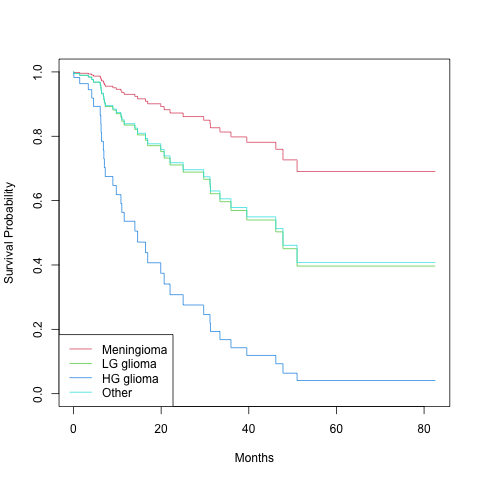

In [30]:
%%R
survplots <- survfit(fit.all, newdata = modaldata)
plot(survplots, xlab = 'Months',
    ylab = 'Survival Probability', col = 2:5)
legend('bottomleft', levels(diagnosis), col = 2:5, lty = 1)

##### Using Lifelines

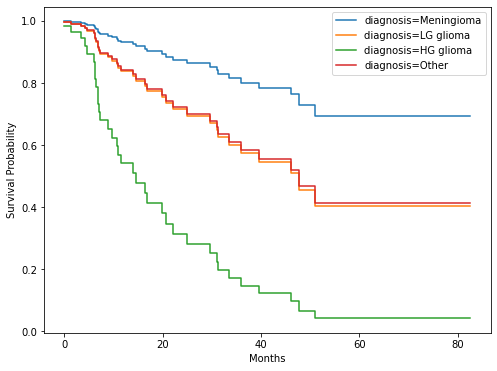

In [31]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
cph_all_ll_fit.plot_partial_effects_on_outcome(covariates='diagnosis', 
                                               values=levels, 
                                               plot_baseline=False, 
                                               ax = ax)
plt.xlabel('Months')
plt.ylabel('Survival Probability');

`lifelines` is able to plot a survival curve based on diagnosis level automatically, as long as the the `covariates=` and `values=` parameters are specified.

## 11.8.2 Publication Data

### Kaplan Meier Survival Curve by posres

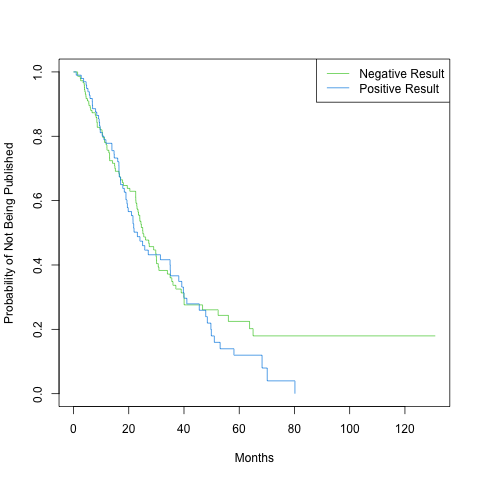

In [32]:
%%R
fit.posres <- survfit(
    Surv(time,  status) ~ posres, data = Publication
)
plot(fit.posres, xlab='Months',
    ylab = 'Probability of Not Being Published', col = 3:4)
legend("topright", c("Negative Result", "Positive Result"),
      col = 3:4, lty = 1)

In [33]:
data = robjects.r("""
library(ISLR2)
xdata <- Publication
""")
with localconverter(robjects.default_converter + pandas2ri.converter):
    publication_df = robjects.conversion.rpy2py(data)

#### Using Lifelines

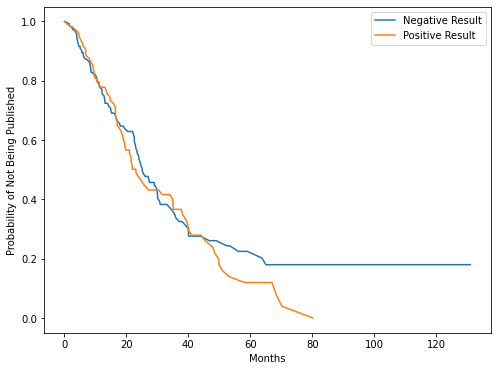

In [34]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

for level in publication_df['posres'].unique():

    idx = (publication_df['posres'] == level)

    if level == 1:
        label = "Positive Result"
    else:
        label = "Negative Result"
        
    kmf_ll.fit(publication_df['time'][idx], 
               event_observed=publication_df['status'][idx], 
               label=label)
    kmf_ll.survival_function_.plot(ax=ax)


plt.xlabel('Months')
plt.yticks(np.arange(0, 1.1, 0.2))
plt.ylabel('Probability of Not Being Published');

### CoxPH by posres

In [35]:
%%R
fit.pub <- coxph(Surv(time, status) ~ posres,
                data = Publication)
fit.pub

Call:
coxph(formula = Surv(time, status) ~ posres, data = Publication)

         coef exp(coef) se(coef)     z    p
posres 0.1481    1.1596   0.1616 0.916 0.36

Likelihood ratio test=0.83  on 1 df, p=0.3611
n= 244, number of events= 156 


#### Using Lifelines and posres as a predictor

In [36]:
cph_ll = CoxPHFitter()
cph_ll_fit = cph_ll.fit(publication_df, 'time', 'status', formula='posres')

cph_ll_fit.print_summary()

<lifelines.CoxPHFitter: fitted with 244 total observations, 88 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 244
number of events observed = 156
   partial log-likelihood = -723.47
         time fit was run = 2023-01-30 07:20:08 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
posres      0.15       1.16       0.16            -0.17             0.46                 0.84                 1.59

            cmp to    z    p   -log2(p)
covariate                              
posres        0.00 0.92 0.36       1.48
---
Concordance = 0.50
Partial AIC = 1448.95
log-likelihood ratio test = 0.83 on 1 df
-log2(p) of ll-ratio test = 1.47

Like before, the output from fitting a CoxPH model using `lifelines` is very similar to that of R.

In [37]:
%%R
logrank.test <- survdiff(Surv(time, status) ~ posres,
                        data = Publication)
logrank.test

Call:
survdiff(formula = Surv(time, status) ~ posres, data = Publication)

           N Observed Expected (O-E)^2/E (O-E)^2/V
posres=0 146       87     92.6     0.341     0.844
posres=1  98       69     63.4     0.498     0.844

 Chisq= 0.8  on 1 degrees of freedom, p= 0.4 


#### Using Lifelines

In [38]:
neg = (publication_df['posres'] == 0)
pos = (publication_df['posres'] == 1)

results = logrank_test(publication_df['time'][neg], 
                       publication_df['time'][pos],
                       event_observed_A=publication_df['status'][neg],
                       event_observed_B=publication_df['status'][pos]
                      )

results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.84 0.36      1.48

Again, `lifelines` can perform a Log-Rank test, however the output is less basic as compared to R.

#### Using scikit-survival

In [39]:
x = []

for item in zip(publication_df['status'].astype(bool), publication_df['time']):
    x.append(item)

x = np.array(x, dtype='bool,f').flatten()

test_stat, p_val, surv_counts, covar = compare_survival(x, publication_df['posres'], return_stats=True)

print(f'Scikit-survival Chi-Square Test Statistic: {test_stat:.3f}')
print(f'Scikit-survival P-Value: {p_val:.4f}')
surv_counts

Scikit-survival Chi-Square Test Statistic: 0.844
Scikit-survival P-Value: 0.3583


/Users/rancher/opt/anaconda3/envs/ox/lib/python3.9/site-packages/sksurv/compare.py:115: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  table.index = pandas.Index(groups, name="group")


,counts,observed,expected,statistic
group,,,,
0,146,87,92.61852,-5.61852
1,98,69,63.38148,5.61852


In [40]:
%%R
fit.pub2 <- coxph(Surv(time, status) ~ . - mech,
                 data = Publication)
fit.pub2

Call:
coxph(formula = Surv(time, status) ~ . - mech, data = Publication)

               coef  exp(coef)   se(coef)      z       p
posres    5.708e-01  1.770e+00  1.760e-01  3.244 0.00118
multi    -4.086e-02  9.600e-01  2.512e-01 -0.163 0.87079
clinend   5.462e-01  1.727e+00  2.620e-01  2.085 0.03710
sampsize  4.678e-06  1.000e+00  1.472e-05  0.318 0.75070
budget    4.385e-03  1.004e+00  2.465e-03  1.779 0.07518
impact    5.832e-02  1.060e+00  6.676e-03  8.735 < 2e-16

Likelihood ratio test=149.2  on 6 df, p=< 2.2e-16
n= 244, number of events= 156 


#### Using Lifelines and all predictors but mech

In [41]:
cph_ll = CoxPHFitter()
cph_ll_fit = cph_ll.fit(publication_df, 'time', 'status', formula='posres + multi + clinend + sampsize + budget + impact')

cph_ll_fit.print_summary()

<lifelines.CoxPHFitter: fitted with 244 total observations, 88 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 244
number of events observed = 156
   partial log-likelihood = -649.26
         time fit was run = 2023-01-30 07:20:08 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
budget      0.00       1.00       0.00            -0.00             0.01                 1.00                 1.01
clinend     0.55       1.73       0.26             0.03             1.06                 1.03                 2.89
impact      0.06       1.06       0.01             0.05             0.07                 1.05                 1.07
multi      -0.04       0.96       0.25            -0.53             0.45                 0.59                 1.57
posres      0.57       1.77       0.18             0.23             0.92                 1.25                 2.50
sampsize    0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00

            cmp to     z      p   -log2(p)
covariate                                 
budget        0.00  1.78   0.08       3.73
clinend       0.00  2.08   0.04       4.75
impact        0.00  8.74 <0.005      58.52
multi         0.00 -0.16   0.87       0.20
posres        0.00  3.24 <0.005       9.73
sampsize      0.00  0.32   0.75       0.41
---
Concordance = 0.80
Partial AIC = 1310.53
log-likelihood ratio test = 149.25 on 6 df
-log2(p) of ll-ratio test = 96.18

## 11.8.3 Call Center Data

In [42]:
%%R
set.seed(4)
N <- 2000
Operators <- sample(5:15, N, replace = T)
Center <- sample(c("A", "B", "C"), N, replace = T)
Time <- sample(c("Morn.", "After.", "Even."), N, replace = T)
X <- model.matrix( ~ Operators + Center + Time)[, -1]

In [43]:
%%R
X[1:5, ]

  Operators CenterB CenterC TimeEven. TimeMorn.
1        12       1       0         0         1
2        15       0       0         0         0
3         7       0       1         1         0
4         7       0       0         0         0
5        11       0       1         0         1


In [44]:
r_data = robjects.r("""
set.seed(4)
N <- 2000
Operators <- sample(5:15, N, replace = T)
Center <- sample(c("A", "B", "C"), N, replace = T)
Time <- sample(c("Morn.", "After.", "Even."), N, replace = T)
X_df = data.frame(Operators, Center, Time)
""")

with localconverter(robjects.default_converter + pandas2ri.converter):
    call_center_df = robjects.conversion.rpy2py(r_data)
    
call_center_df_dummies = pd.get_dummies(call_center_df, columns=['Center', 'Time'], drop_first=True)

call_center_df_dummies[0:5]

,Operators,Center_B,Center_C,Time_Even.,Time_Morn.
1,12,1,0,0,1
2,15,0,0,0,0
3,7,0,1,1,0
4,7,0,0,0,0
5,11,0,1,0,1


In [45]:
%%R
true.beta <- c(0.04, -0.3, 0, 0.2, -0.2)
h.fn <- function(x) return(0.00001 * x)

In [46]:
%%R
library(coxed)

R[write to console]: Loading required package: rms

R[write to console]: Loading required package: Hmisc

R[write to console]: Loading required package: lattice

R[write to console]: Loading required package: Formula

R[write to console]: Loading required package: ggplot2

R[write to console]: 
Attaching package: ‘Hmisc’


R[write to console]: The following objects are masked from ‘package:base’:

    format.pval, units


R[write to console]: Loading required package: SparseM

R[write to console]: 
Attaching package: ‘SparseM’


R[write to console]: The following object is masked from ‘package:base’:

    backsolve


R[write to console]: Loading required package: mgcv

R[write to console]: Loading required package: nlme

R[write to console]: This is mgcv 1.8-40. For overview type 'help("mgcv-package")'.



In [47]:
%%R
queuing <- sim.survdata(N = N, T = 1000, X = X,
beta = true.beta, hazard.fun = h.fn)

names(queuing)

[1] "data"             "xdata"            "baseline"         "xb"              
[5] "exp.xb"           "betas"            "ind.survive"      "marg.effect"     
[9] "marg.effect.data"


Because of the randomness when generating simulated survival data using `sim.survdata` in R, it would be difficult to reproduce in Python, however by accessing the data property of the simulated data, I can use the `robjects` library to get it into Python.

In [48]:
r_data = robjects.r("""
queuing_data <- queuing$data
""")

with localconverter(robjects.default_converter + pandas2ri.converter):
    queuing_df = robjects.conversion.rpy2py(r_data)

In [49]:
%%R
head(queuing$data)

  Operators CenterB CenterC TimeEven. TimeMorn.   y failed
1        12       1       0         0         1 344   TRUE
2        15       0       0         0         0 241   TRUE
3         7       0       1         1         0 187   TRUE
4         7       0       0         0         0 279   TRUE
5        11       0       1         0         1 954   TRUE
6         7       1       0         0         1 455   TRUE


In [50]:
queuing_df.head()

,Operators,CenterB,CenterC,TimeEven.,TimeMorn.,y,failed
1,12.0,1.0,0.0,0.0,1.0,344,True
2,15.0,0.0,0.0,0.0,0.0,241,True
3,7.0,0.0,1.0,1.0,0.0,187,True
4,7.0,0.0,0.0,0.0,0.0,279,True
5,11.0,0.0,1.0,0.0,1.0,954,True


In [51]:
%%R
mean(queuing$data$failed)

[1] 0.89


In [52]:
queuing_df['failed'].mean()

0.89

In [53]:
%%R
par(mfrow = c(1,2))
fit.Center <- survfit(Surv(y, failed) ~ Center,
                      data = queuing$data)

#### Using Lifelines
In `lifelines`, if we want to segment by different levels of a predictor, we have to fit a KaplanMeier curve separately for each level.

In [54]:
center_b_idx = (queuing_df['CenterB'] == 1)
center_c_idx = (queuing_df['CenterC'] == 1)
center_a_idx = (~(center_b_idx) & ~(center_c_idx))

kmf_ll_a = KaplanMeierFitter(label='Call Center A')
kmf_ll_a.fit(durations=queuing_df['y'][center_a_idx], 
             event_observed=queuing_df['failed'][center_a_idx])

kmf_ll_b = KaplanMeierFitter(label='Call Center B')
kmf_ll_b.fit(durations=queuing_df['y'][center_b_idx], 
             event_observed=queuing_df['failed'][center_b_idx])

kmf_ll_c = KaplanMeierFitter(label='Call Center C')
kmf_ll_c.fit(durations=queuing_df['y'][center_c_idx],
             event_observed=queuing_df['failed'][center_c_idx])

<lifelines.KaplanMeierFitter:"Call Center C", fitted with 650 total observations, 73 right-censored observations>

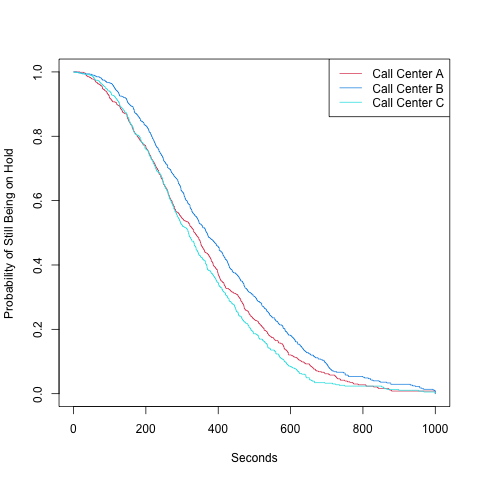

In [55]:
%%R
plot(fit.Center, xlab = 'Seconds',
    ylab = 'Probability of Still Being on Hold',
    col = c(2, 4, 5))
legend("topright",
      c("Call Center A", "Call Center B", "Call Center C"),
      col = c(2, 4, 5), lty = 1)

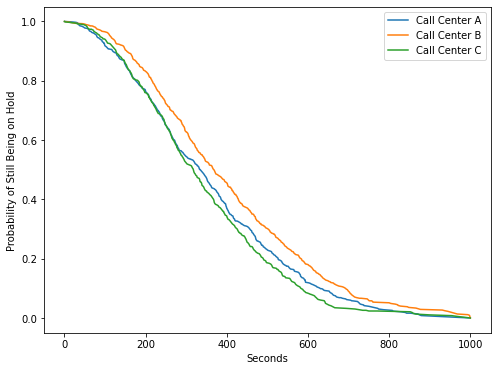

In [56]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

kmf_ll_a.survival_function_.plot(ax=ax)
plt.xlabel('Seconds')
plt.yticks(np.arange(0, 1.1, 0.2))
plt.ylabel('Probability of Still Being on Hold')

kmf_ll_b.survival_function_.plot(ax=ax)
plt.xlabel('Seconds')
plt.yticks(np.arange(0, 1.1, 0.2))
plt.ylabel('Probability of Still Being on Hold')


kmf_ll_c.survival_function_.plot(ax=ax)
plt.xlabel('Seconds')
plt.yticks(np.arange(0, 1.1, 0.2))
plt.ylabel('Probability of Still Being on Hold');

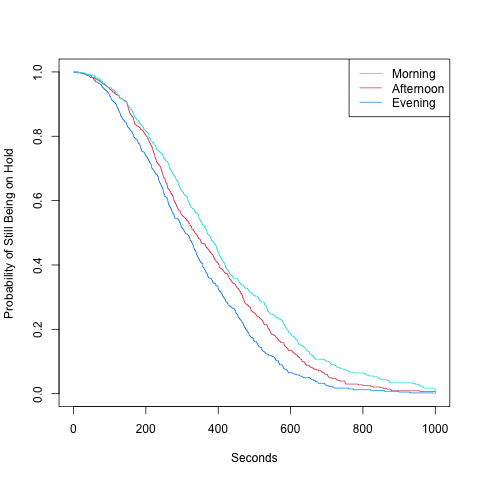

In [57]:
%%R
fit.Time <- survfit(Surv(y, failed) ~ Time,
                    data = queuing$data)
plot(fit.Time, xlab = "Seconds",
    ylab = 'Probability of Still Being on Hold',
    col = c(2, 4, 5))
legend("topright", c("Morning", "Afternoon", "Evening"),
      col = c(5, 2, 4), lty = 1)

#### Using Lifelines

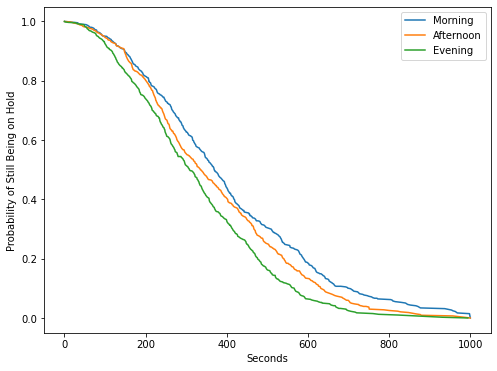

In [58]:
time_morn_idx = (queuing_df['TimeMorn.'] == 1)
time_even_idx = (queuing_df['TimeEven.'] == 1)
time_after_idx = (~(time_morn_idx) & ~(time_even_idx))

kmf_ll_morn = KaplanMeierFitter(label='Morning')
kmf_ll_morn.fit(durations=queuing_df['y'][time_morn_idx], 
             event_observed=queuing_df['failed'][time_morn_idx])

kmf_ll_after = KaplanMeierFitter(label='Afternoon')
kmf_ll_after.fit(durations=queuing_df['y'][time_after_idx], 
             event_observed=queuing_df['failed'][time_after_idx])

kmf_ll_even = KaplanMeierFitter(label='Evening')
kmf_ll_even.fit(durations=queuing_df['y'][time_even_idx],
             event_observed=queuing_df['failed'][time_even_idx])

fig, ax = plt.subplots(1,1, figsize=(8,6))

kmf_ll_morn.survival_function_.plot(ax=ax)
plt.xlabel('Seconds')
plt.yticks(np.arange(0, 1.1, 0.2))
plt.ylabel('Probability of Still Being on Hold')

kmf_ll_after.survival_function_.plot(ax=ax)
plt.xlabel('Seconds')
plt.yticks(np.arange(0, 1.1, 0.2))
plt.ylabel('Probability of Still Being on Hold')


kmf_ll_even.survival_function_.plot(ax=ax)
plt.xlabel('Seconds')
plt.yticks(np.arange(0, 1.1, 0.2))
plt.ylabel('Probability of Still Being on Hold');

In [59]:
%%R
survdiff(Surv(y, failed) ~ Center, data = queuing$data)

Call:
survdiff(formula = Surv(y, failed) ~ Center, data = queuing$data)

           N Observed Expected (O-E)^2/E (O-E)^2/V
Center=A 683      603      579     0.971      1.45
Center=B 667      600      701    14.641     24.64
Center=C 650      577      499    12.062     17.05

 Chisq= 28.3  on 2 degrees of freedom, p= 7e-07 


#### Using scikit-survival
Again, `scikit-survival` does a good job of recreating most of the output of R's `survdiff()` function.

In [60]:
centers = call_center_df['Center'].values
x = []

for item in zip(queuing_df['failed'].astype(bool), queuing_df['y']):
    x.append(item)

x = np.array(x, dtype='bool,f').flatten()

test_stat, p_val, surv_counts, covar = compare_survival(x, centers, return_stats=True)

print(f'Scikit-survival Chi-Square Test Statistic: {test_stat:.3f}')
print(f'Scikit-survival P-Value: {p_val:.4f}')
surv_counts

Scikit-survival Chi-Square Test Statistic: 28.261
Scikit-survival P-Value: 0.0000


,counts,observed,expected,statistic
group,,,,
A,683,603,579.281031,23.718969
B,667,600,701.330745,-101.330745
C,650,577,499.388224,77.611776


In [61]:
%%R
survdiff(Surv(y, failed) ~ Time, data = queuing$data)

Call:
survdiff(formula = Surv(y, failed) ~ Time, data = queuing$data)

              N Observed Expected (O-E)^2/E (O-E)^2/V
Time=After. 688      616      619    0.0135     0.021
Time=Even.  653      582      468   27.6353    38.353
Time=Morn.  659      582      693   17.7381    29.893

 Chisq= 46.8  on 2 degrees of freedom, p= 7e-11 


#### Using scikit-survival

In [62]:
times = call_center_df['Time']
x = []

for item in zip(queuing_df['failed'].astype(bool), queuing_df['y']):
    x.append(item)

x = np.array(x, dtype='bool,f').flatten()

test_stat, p_val, surv_counts, covar = compare_survival(x, times, return_stats=True)

print(f'Scikit-survival Chi-Square Test Statistic: {test_stat:.3f}')
print(f'Scikit-survival P-Value: {p_val}')
surv_counts

Scikit-survival Chi-Square Test Statistic: 46.787
Scikit-survival P-Value: 6.925298148953775e-11


,counts,observed,expected,statistic
group,,,,
After.,688,616,618.894245,-2.894245
Even.,653,582,468.245400,113.754600
Morn.,659,582,692.860355,-110.860355


In [63]:
%%R
fit.queuing <- coxph(Surv(y, failed) ~ .,
                    data = queuing$data)
fit.queuing

Call:
coxph(formula = Surv(y, failed) ~ ., data = queuing$data)

              coef exp(coef) se(coef)      z        p
Operators  0.04174   1.04263  0.00759  5.500  3.8e-08
CenterB   -0.21879   0.80349  0.05793 -3.777 0.000159
CenterC    0.07930   1.08253  0.05850  1.356 0.175256
TimeEven.  0.20904   1.23249  0.05820  3.592 0.000328
TimeMorn. -0.17352   0.84070  0.05811 -2.986 0.002828

Likelihood ratio test=102.8  on 5 df, p=< 2.2e-16
n= 2000, number of events= 1780 


In [64]:
y = np.array(queuing_df['y'])
failed = np.array(queuing_df['failed'])

call_center_df['y'] = y
call_center_df['failed'] = failed

#### Using Lifelines

In [65]:
cph_ll = CoxPHFitter()
cph_ll_fit = cph_ll.fit(call_center_df, 'y', 'failed', formula='Operators + Center + Time')

cph_ll_fit.print_summary()

<lifelines.CoxPHFitter: fitted with 2000 total observations, 220 right-censored observations>
             duration col = 'y'
                event col = 'failed'
      baseline estimation = breslow
   number of observations = 2000
number of events observed = 1780
   partial log-likelihood = -11699.73
         time fit was run = 2023-01-30 07:20:12 UTC

---
                coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                             
Center[T.B]    -0.22       0.80       0.06            -0.33            -0.11                 0.72                 0.90
Center[T.C]     0.08       1.08       0.06            -0.04             0.19                 0.97                 1.21
Operators       0.04       1.04       0.01             0.03             0.06                 1.03                 1.06
Time[T.Even.]   0.21       1.23       0.06             0.09             0.32                 1.10                 1.38
Time[T.Morn.]  -0.17       0.84       0.06            -0.29            -0.06                 0.75                 0.94

                cmp to     z      p   -log2(p)
covariate                                     
Center[T.B]       0.00 -3.78 <0.005      12.62
Center[T.C]       0.00  1.36   0.18       2.51
Operators         0.00  5.50 <0.005      24.65
Time[T.Even.]     0.00  3.59 <0.005      11.57
Time[T.Morn.]     0.00 -2.99 <0.005       8.47
---
Concordance = 0.57
Partial AIC = 23409.45
log-likelihood ratio test = 102.81 on 5 df
-log2(p) of ll-ratio test = 66.00

The End